# Combination of lgbm and iforest

- lgbm will focus on precision
- iforest will focus on recall

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyod.models.iforest import IForest
import lightgbm as lgb
import optuna
from scipy.stats import percentileofscore
from joblib import dump, load

import scripts.feature as feat
import scripts.utility as util


In [2]:
class FirmEncoder:
    def __init__(self, firms):
        self.encoder = LabelEncoder()
        self.encoder.fit(firms)

        self.scaler = StandardScaler()
        self.scaler.fit(self.encoder.transform(firms).reshape(-1, 1))
    
    def encode(self, firm):
        code = self.encoder.transform([firm]).reshape(-1, 1)
        return self.scaler.transform(code)[0][0]

In [3]:
def multi_ticker_dataset_pipeline_cv(
    ticker_list, obj=[5, 0.05], normalize=False, extend=None, binary=False, cv=1
):
    encoder = FirmEncoder(ticker_list)

    cv_dataset = {}
    for fold in range(1, cv + 1):
        cv_dataset[fold] = {"X_train": [], "y_train": [], "X_val": [], "y_val": []}

    for ticker in ticker_list:
        df = yf.download(ticker, period="5y", interval="1d", progress=False)
        df = df.drop(columns=["Adj Close"])

        firm = encoder.encode(ticker)
        data = feat.tabular_data_prep(
            df, obj=[5, 0.05], norm=normalize, extend=3, firm=firm
        )

        if binary:
            data.loc[:, "entry"] = np.where(data["entry"] == 2, 1, 0)

        one_fold = int(len(df) / cv)
        for i in range(1, cv + 1):
            cv_data = data[: one_fold * i]
            train, val = util.split_train_val(cv_data, 0.8)

            cv_dataset[i]["X_train"].append(train.drop(columns=["entry"]))
            cv_dataset[i]["y_train"].append(train["entry"])
            cv_dataset[i]["X_val"].append(val.drop(columns=["entry"]))
            cv_dataset[i]["y_val"].append(val["entry"])

    for i in range(1, cv + 1):
        cv_dataset[i]["X_train"] = np.vstack(cv_dataset[i]["X_train"])
        cv_dataset[i]["y_train"] = np.hstack(cv_dataset[i]["y_train"])
        cv_dataset[i]["X_val"] = np.vstack(cv_dataset[i]["X_val"])
        cv_dataset[i]["y_val"] = np.hstack(cv_dataset[i]["y_val"])
        print(cv_dataset[i]["X_train"].shape, cv_dataset[i]["X_val"].shape)
        print(np.unique(cv_dataset[i]["y_train"], return_counts=True))
        print(np.unique(cv_dataset[i]["y_val"], return_counts=True))

    return cv_dataset


def single_class_report(y_true, y_pred, label):
    instance = np.where(y_true == label)[0]
    predict = np.where(y_pred == label)[0]
    correct = np.intersect1d(instance, predict)

    precision = len(correct) / (len(predict) + 0.01)
    recall = len(correct) / (len(instance) + 0.01)

    def fbeta_score(b):
        return (1 + b**2) * (precision * recall) / (b**2 * precision + recall + 0.01)

    f_rec = fbeta_score(b=4)     # focus more on recall
    f_pre = fbeta_score(b=0.25)  # focus more on precision

    return [recall, precision, f_rec, f_pre]

def product_dataset_pipeline(ticker_list, normalize=False, extend=None, binary=False, period="5y"):
    encoder = FirmEncoder(ticker_list)
    X, y = [], []

    for ticker in ticker_list:
        df = yf.download(ticker, period=period, interval="1d", progress=False)
        df = df.drop(columns=["Adj Close"])

        firm = encoder.encode(ticker)
        data = feat.tabular_data_prep(df, obj=[5, 0.05], norm=normalize, extend=3, firm=firm)

        if binary:
            data.loc[:, "entry"] = np.where(data["entry"] == 2, 1, 0)

        X.append(data.drop(columns=["entry"]))
        y.append(data["entry"])

    X = np.vstack(X)
    y = np.hstack(y)
    print(X.shape, y.shape)
    print(np.unique(y, return_counts=True))

    return X, y, df

# settings

In [4]:
ticker_list = ["TSLA", "NVDA", "AMZN", "AAPL", "MSFT", "AMD", "GOOG", "META", "NFLX"]
# ticker_list = ["TSLA", "NVDA", "AMZN", "AAPL"]

cv = 3


# final iforest tuning (binary raw data)

In [5]:
cv_dataset = multi_ticker_dataset_pipeline_cv(
    ticker_list, obj=[5, 0.05], normalize=False, extend=3, binary=True, cv=cv
)

(3015, 101) (756, 101)
(array([0, 1], dtype=int64), array([1950, 1065], dtype=int64))
(array([0, 1], dtype=int64), array([551, 205], dtype=int64))
(6030, 101) (1512, 101)
(array([0, 1], dtype=int64), array([4184, 1846], dtype=int64))
(array([0, 1], dtype=int64), array([927, 585], dtype=int64))
(8802, 101) (2205, 101)
(array([0, 1], dtype=int64), array([5900, 2902], dtype=int64))
(array([0, 1], dtype=int64), array([1644,  561], dtype=int64))


In [6]:
studies = {}
for i in range(1, cv + 1):
    X_train = cv_dataset[i]["X_train"]
    X_val = cv_dataset[i]["X_val"]
    y_val = cv_dataset[i]["y_val"]

    def objective_iforest(trial):
        n_estimators = trial.suggest_int("n_estimators", 100, 800)
        max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
        contamination = trial.suggest_float("contamination", 0.1, 0.5)
        max_features = trial.suggest_float("max_features", 0.4, 1.0)

        model = IForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=123
        )
        model.fit(X_train)

        y_pred = model.predict(X_val)
        score = single_class_report(y_val, y_pred, label=1)

        return score[2]

    study = optuna.create_study(direction="maximize")
    study.enqueue_trial(
        {"n_estimators": 170, "max_samples": 0.6, "contamination": 0.34}
    )
    study.optimize(objective_iforest, n_trials=100)

    studies[i] = study

[I 2024-07-25 15:43:05,523] A new study created in memory with name: no-name-c1aa2fc3-af9c-40c5-be76-a6313b504069
[I 2024-07-25 15:43:06,432] Trial 0 finished with value: 0.3523796355122233 and parameters: {'n_estimators': 170, 'max_samples': 0.6, 'contamination': 0.34, 'max_features': 0.4420328641893789}. Best is trial 0 with value: 0.3523796355122233.
[I 2024-07-25 15:43:10,500] Trial 1 finished with value: 0.23326876853544534 and parameters: {'n_estimators': 704, 'max_samples': 0.8594772229378171, 'contamination': 0.2067036639435992, 'max_features': 0.6493139607420091}. Best is trial 0 with value: 0.3523796355122233.
[I 2024-07-25 15:43:15,192] Trial 2 finished with value: 0.3877942467148882 and parameters: {'n_estimators': 739, 'max_samples': 0.4747929278012307, 'contamination': 0.3777514352038426, 'max_features': 0.9867769272446767}. Best is trial 2 with value: 0.3877942467148882.
[I 2024-07-25 15:43:18,480] Trial 3 finished with value: 0.2661364313257502 and parameters: {'n_estim

In [7]:
for name, study in studies.items():
    print(study.best_trial)

FrozenTrial(number=52, state=TrialState.COMPLETE, values=[0.5717125007500762], datetime_start=datetime.datetime(2024, 7, 25, 15, 44, 36, 388216), datetime_complete=datetime.datetime(2024, 7, 25, 15, 44, 37, 704822), params={'n_estimators': 439, 'max_samples': 0.9527329073978987, 'contamination': 0.4995561087536344, 'max_features': 0.7821760806589094}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=800, log=False, low=100, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'contamination': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'max_features': FloatDistribution(high=1.0, log=False, low=0.4, step=None)}, trial_id=52, value=None)
FrozenTrial(number=61, state=TrialState.COMPLETE, values=[0.8569050006767736], datetime_start=datetime.datetime(2024, 7, 25, 15, 48, 4, 853633), datetime_complete=datetime.datetime(2024, 7, 25, 15, 48, 7, 245799), params={'n_estimators': 348, 'max_sa

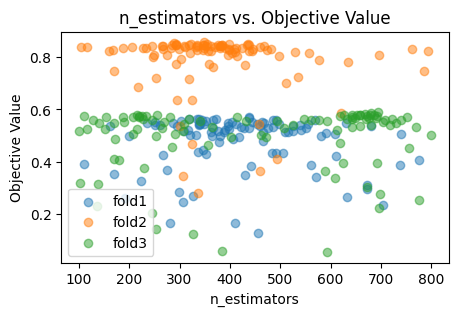

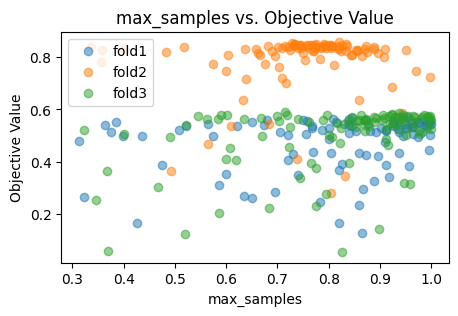

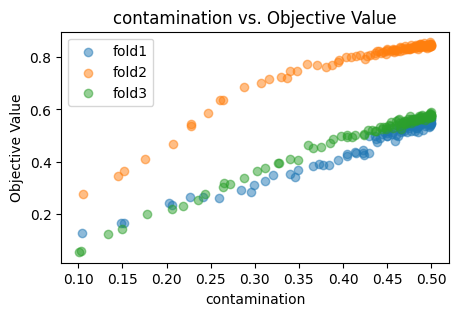

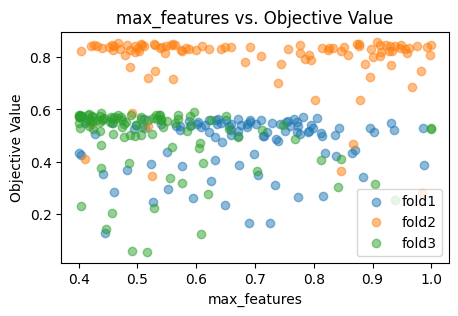

In [8]:
def plot_param_vs_objective(studies, param_name):
    plt.figure(figsize=(5, 3))

    for name, study in studies.items():
        trials = study.trials
        param_values = [trial.params[param_name] for trial in trials]
        objective_values = [trial.value for trial in trials]

        plt.scatter(param_values, objective_values, alpha=0.5, label=f"fold{name}")
        plt.xlabel(param_name)
        plt.ylabel("Objective Value")

    plt.legend()
    plt.title(f"{param_name} vs. Objective Value")
    plt.show()

plot_param_vs_objective(studies, "n_estimators")
plot_param_vs_objective(studies, "max_samples")
plot_param_vs_objective(studies, "contamination")
plot_param_vs_objective(studies, "max_features")

# final lgbm tuning (multi raw data)

In [9]:
cv_dataset = multi_ticker_dataset_pipeline_cv(
    ticker_list, obj=[5, 0.05], normalize=False, extend=3, binary=False, cv=cv
)

(3015, 101) (756, 101)
(array([0, 1, 2], dtype=int64), array([ 647, 1303, 1065], dtype=int64))
(array([0, 1, 2], dtype=int64), array([206, 345, 205], dtype=int64))
(6030, 101) (1512, 101)
(array([0, 1, 2], dtype=int64), array([1506, 2678, 1846], dtype=int64))
(array([0, 1, 2], dtype=int64), array([602, 325, 585], dtype=int64))
(8802, 101) (2205, 101)
(array([0, 1, 2], dtype=int64), array([2334, 3566, 2902], dtype=int64))
(array([0, 1, 2], dtype=int64), array([ 459, 1185,  561], dtype=int64))


In [10]:
studies = {}
for i in range(1, cv + 1):
    X_train = cv_dataset[i]["X_train"]
    y_train = cv_dataset[i]["y_train"]
    X_val = cv_dataset[i]["X_val"]
    y_val = cv_dataset[i]["y_val"]

    def objective_lgbm(trial):
        param = {
            "objective": "multiclass",
            "metric": "multi_logloss",
            "num_class": 3,
            "verbosity": -1,
            # controls tree structure
            "num_leaves": trial.suggest_int("num_leaves", 16, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 16),
            # for accuracy
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            # controls overfitting
            "lambda_l1": trial.suggest_int("lambda_l1", 0.1, 100),
            "lambda_l2": trial.suggest_int("lambda_l2", 0.1, 100),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1),
            "random_state": 123
        }

        gbm = lgb.LGBMClassifier(**param)
        gbm.fit(X_train, y_train)

        y_pred = gbm.predict(X_val)
        score = single_class_report(y_val, y_pred, label=2)

        return score[3]

    study = optuna.create_study(direction="maximize")
    study.enqueue_trial(
        {"num_leaves": 160,
        "max_depth": 9, 
        "learning_rate": 0.17, 
        "lambda_l1": 70, 
        "lambda_l2": 30, 
        "bagging_fraction": 0.33}
    )
    study.optimize(objective_lgbm, n_trials=100)

    studies[i] = study

[I 2024-07-25 15:55:03,367] A new study created in memory with name: no-name-b90c0394-6959-4a8d-a799-8264b09158f2
[I 2024-07-25 15:55:03,882] Trial 0 finished with value: 0.3109766161494311 and parameters: {'num_leaves': 160, 'max_depth': 9, 'learning_rate': 0.17, 'lambda_l1': 70, 'lambda_l2': 30, 'bagging_fraction': 0.33}. Best is trial 0 with value: 0.3109766161494311.
[I 2024-07-25 15:55:04,084] Trial 1 finished with value: 0.30662406257280606 and parameters: {'num_leaves': 215, 'max_depth': 3, 'learning_rate': 0.224356127494612, 'lambda_l1': 31, 'lambda_l2': 86, 'bagging_fraction': 0.2322169936854108}. Best is trial 0 with value: 0.3109766161494311.
[I 2024-07-25 15:55:04,220] Trial 2 finished with value: 0.3076346613564794 and parameters: {'num_leaves': 318, 'max_depth': 5, 'learning_rate': 0.08189900424335887, 'lambda_l1': 66, 'lambda_l2': 50, 'bagging_fraction': 0.4398780542705365}. Best is trial 0 with value: 0.3109766161494311.
[I 2024-07-25 15:55:04,383] Trial 3 finished with

In [11]:
for name, study in studies.items():
    print(study.best_trial)

FrozenTrial(number=81, state=TrialState.COMPLETE, values=[0.32935553112167854], datetime_start=datetime.datetime(2024, 7, 25, 15, 55, 27, 539579), datetime_complete=datetime.datetime(2024, 7, 25, 15, 55, 27, 782656), params={'num_leaves': 427, 'max_depth': 14, 'learning_rate': 0.23490253908347208, 'lambda_l1': 54, 'lambda_l2': 61, 'bagging_fraction': 0.8507382154425406}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=500, log=False, low=16, step=1), 'max_depth': IntDistribution(high=16, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'lambda_l1': IntDistribution(high=100, log=False, low=0, step=1), 'lambda_l2': IntDistribution(high=100, log=False, low=0, step=1), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.2, step=None)}, trial_id=81, value=None)
FrozenTrial(number=50, state=TrialState.COMPLETE, values=[0.453768790560762], datetime_start=datetime.date

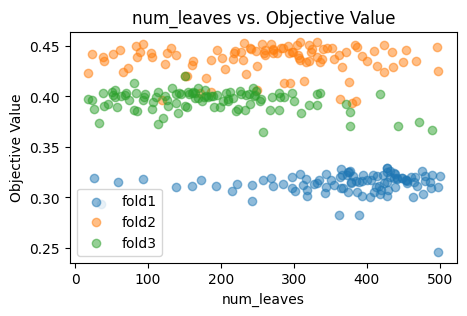

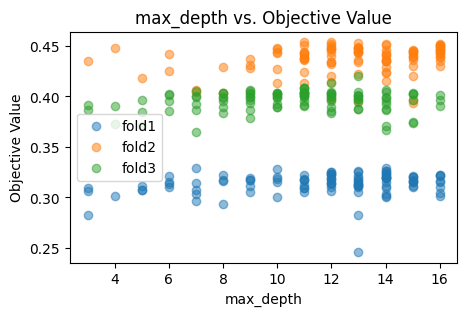

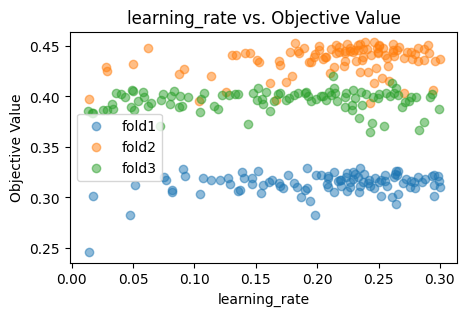

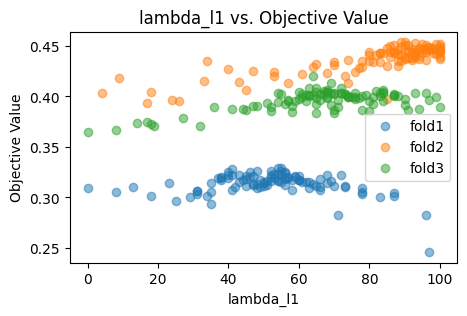

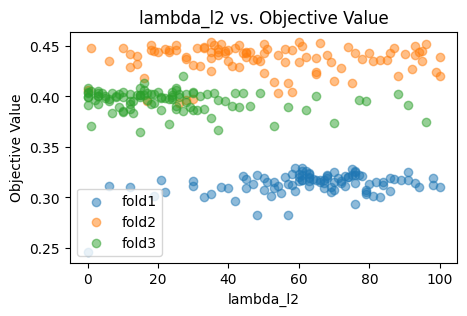

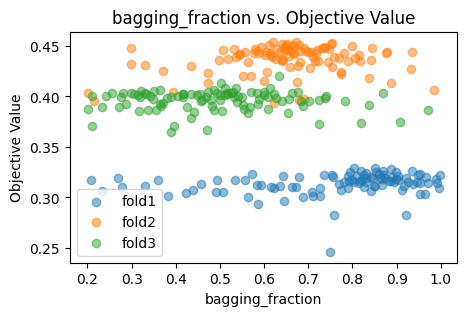

In [12]:
def plot_param_vs_objective(studies, param_name):
    plt.figure(figsize=(5, 3))

    for name, study in studies.items():
        trials = study.trials
        param_values = [trial.params[param_name] for trial in trials]
        objective_values = [trial.value for trial in trials]

        plt.scatter(param_values, objective_values, alpha=0.5, label=f"fold{name}")
        plt.xlabel(param_name)
        plt.ylabel("Objective Value")

    plt.legend()
    plt.title(f"{param_name} vs. Objective Value")
    plt.show()

plot_param_vs_objective(studies, "num_leaves")
plot_param_vs_objective(studies, "max_depth")
plot_param_vs_objective(studies, "learning_rate")
plot_param_vs_objective(studies, "lambda_l1")
plot_param_vs_objective(studies, "lambda_l2")
plot_param_vs_objective(studies, "bagging_fraction")



# create final model

## iforest

In [13]:
cv_dataset = multi_ticker_dataset_pipeline_cv(
    ticker_list, obj=[5, 0.05], normalize=False, extend=3, binary=True, cv=1
)

X_train = cv_dataset[1]["X_train"]
y_train = cv_dataset[1]["y_train"]

X_val = cv_dataset[1]["X_val"]
y_val = cv_dataset[1]["y_val"]

forest_param = {
    "n_estimators": 550,
    "max_samples": 0.4,
    "contamination": 0.5,
    "max_features": 0.45,
    "random_state": 123
}

forest = IForest(**forest_param)
forest.fit(X_train)

# y_pred = model.predict(X_val)
# score = single_class_report(y_val, y_pred, label=1)

(8802, 101) (2205, 101)
(array([0, 1], dtype=int64), array([5900, 2902], dtype=int64))
(array([0, 1], dtype=int64), array([1644,  561], dtype=int64))


IForest(behaviour='old', bootstrap=False, contamination=0.5,
    max_features=0.45, max_samples=0.4, n_estimators=550, n_jobs=1,
    random_state=123, verbose=0)

In [15]:
X_pred = forest.decision_function(X_train)
for i in np.percentile(X_pred, [40, 50, 60, 70, 80]):
    pred = np.where(X_pred > i, 1, 0)
    print(single_class_report(y_train, pred, label=1))

[0.6909004448640769, 0.37966222370342034, 0.6581436357511814, 0.38461470739688375]
[0.6075099672296098, 0.40058986459926244, 0.588756288082446, 0.40241810852755716]
[0.5103359395729167, 0.4206179476911454, 0.5033168900403803, 0.4172378999276721]
[0.4021350718984428, 0.4418764033456897, 0.4037335456567465, 0.429332271728212]
[0.2822181867050768, 0.4650740200226007, 0.2885262845695924, 0.4340553789855503]


In [16]:
percentiles = [percentileofscore(X_pred, x, kind='rank') for x in X_pred]


In [17]:
X_pred = forest.decision_function(X_val)
for i in np.percentile(X_pred, [40, 50, 60, 70, 80]):
    pred = np.where(X_pred > i, 1, 0)
    print(single_class_report(y_val, pred, label=1))

[0.7272597636405769, 0.30838769170301056, 0.6722648864863732, 0.31498298032396915]
[0.6523947879716939, 0.3321203981815047, 0.6163409540542102, 0.33699032187508776]
[0.5597048180959341, 0.3560050339565311, 0.540615623061307, 0.3576476144365122]
[0.4563198516960482, 0.38670110723402973, 0.45085935593768284, 0.38224757272046256]
[0.32441489456515926, 0.41268905466996214, 0.32807522232901315, 0.3949111250304566]


## lgbm

In [18]:
cv_dataset = multi_ticker_dataset_pipeline_cv(
    ticker_list, obj=[5, 0.05], normalize=False, extend=3, binary=False, cv=1
)

X_train = cv_dataset[1]["X_train"]
y_train = cv_dataset[1]["y_train"]
X_val = cv_dataset[1]["X_val"]
y_val = cv_dataset[1]["y_val"]

lgbm_param = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "verbosity": -1,
    # controls tree structure
    "num_leaves": 400,
    "max_depth": 10,
    # for accuracy
    "learning_rate": 0.2,
    # controls overfitting
    "lambda_l1": 65,
    "lambda_l2": 40,
    "bagging_fraction": 0.9,
    "random_state": 123
}

gbm = lgb.LGBMClassifier(**lgbm_param)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_val)
score = single_class_report(y_val, y_pred, label=2)

(8802, 101) (2205, 101)
(array([0, 1, 2], dtype=int64), array([2334, 3566, 2902], dtype=int64))
(array([0, 1, 2], dtype=int64), array([ 459, 1185,  561], dtype=int64))


In [19]:
for i in [.3, .4, .5, .6, .7]:
    prob = gbm.predict_proba(X_train)[:, 2]
    pred = np.where(prob > i, 2, 0)
    print(single_class_report(y_train, pred, label=2))

[0.8108173300574428, 0.4464040098576933, 0.7726947534427469, 0.45312377505722784]
[0.5706389709201553, 0.5481610454781679, 0.5686570713950839, 0.5404987871519632]
[0.18676710280116193, 0.7066400698817487, 0.19504558917876685, 0.5820132905231131]
[0.00516883125833474, 0.9369144284821985, 0.005486331661815339, 0.06979119719785663]
[0.0, 0.0, 0.0, 0.0]


# Combining two model results

In [20]:
X_lgbm, y_lgbm, _ = product_dataset_pipeline(ticker_list, normalize=False, extend=None, binary=False, period="5y")

(11007, 101) (11007,)
(array([0, 1, 2], dtype=int64), array([2793, 4751, 3463], dtype=int64))


In [21]:
lgb_model = lgb.LGBMClassifier(**lgbm_param)
lgb_model.fit(X_lgbm, y_lgbm)
dump(lgb_model, "lgb_model.joblib")

lgbm_prob = lgb_model.predict_proba(X_lgbm)[:, 2] * 100

In [22]:
for i in [.2, .3, .36, .45, .5, .6]:
    prob = lgb_model.predict_proba(X_lgbm)[:, 2]
    pred = np.where(prob > i, 2, 0)
    print(i, single_class_report(y_lgbm, pred, label=2))

0.2 [0.9260729827519989, 0.38905691003650367, 0.8553317496508087, 0.3986025669416866]
0.3 [0.782267449415393, 0.44717654807436763, 0.7482986251230935, 0.45314270107703264]
0.36 [0.6708037227729634, 0.5015101435445951, 0.6569873793034489, 0.5019191897992226]
0.45 [0.35951383334151504, 0.610291126023892, 0.3680555049016034, 0.5718559772904471]
0.5 [0.1712383158004164, 0.7170409063977461, 0.17911121583879508, 0.5771156191154502]
0.6 [0.0023101290495840324, 0.9987515605493134, 0.0024526227500148573, 0.032803142872591895]


In [23]:
X_forest, y_forest, _ = product_dataset_pipeline(ticker_list, normalize=False, extend=None, binary=True, period="5y")

(11007, 101) (11007,)
(array([0, 1], dtype=int64), array([7544, 3463], dtype=int64))


In [24]:
forest = IForest(**forest_param)
forest.fit(X_forest)
dump(forest, "iforest_model.joblib")

forest_pred = forest.decision_function(X_forest)
forest_pct = [percentileofscore(forest_pred, x, kind="rank") for x in forest_pred]
forest_pct = np.array(forest_pct) / 2

In [25]:
for i in np.percentile(forest_pred, [40, 50, 60, 70, 80]):
    pred = np.where(forest_pred > i, 1, 0)
    print(single_class_report(y_forest, pred, label=1))

[0.7083433198287039, 0.37144098812691073, 0.6714552810693213, 0.37697905317688346]
[0.6260449724372728, 0.3939662112189511, 0.6042059211580276, 0.39665256450612857]
[0.5252655926491693, 0.4131264748433458, 0.5162868831256375, 0.4109239829751236]
[0.4215985515490859, 0.44215492987604516, 0.42219147826134173, 0.431289822729587]
[0.28876613119800404, 0.4541305443662835, 0.2946967116862047, 0.425902239566631]


In [26]:
for i in [20, 25, 30, 35]:
    pred = np.where(np.array(forest_pct) > i, 1, 0)
    print(i, single_class_report(y_forest, pred, label=1))

20 [0.7083433198287039, 0.3713847518777413, 0.671444317072987, 0.3769237649696551]
25 [0.6263337385684707, 0.39407631890203687, 0.604474947731093, 0.39676887847504333]
30 [0.5252655926491693, 0.4131264748433458, 0.5162868831256375, 0.4109239829751236]
35 [0.4215985515490859, 0.4420210656340731, 0.4221841265160057, 0.43116710313781137]


# Visualizing result

In [27]:
def plot_prediction(daily, ticker):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.1, 
                        subplot_titles=(" ", "AI score"),
                        row_heights=[0.7, 0.3])

    fig.add_trace(go.Candlestick(
        x=daily.index,
        open=daily["Open"],
        high=daily["High"],
        low=daily["Low"],
        close=daily["Close"],
        name="Candlesticks"
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        x=daily.index,
        y=daily["lgbm_prob"],
        name="lgbm_prob",
        opacity=0.7,
        marker_color="green",
    ), row=2, col=1)

    fig.add_hline(y=20, row=2, col=1, annotation_text="Better not trade", annotation_position="bottom left")
    fig.add_hline(
        y=36, row=2, col=1,
        line_color="red",
        annotation_text="50 - 50", 
        annotation_position="bottom left",
        annotation_font_color="red")
    fig.add_hline(y=45, row=2, col=1, annotation_text="60+ chance", annotation_position="bottom left")

    # Update layout
    fig.update_layout(
        title=ticker,
        autosize=True,
        showlegend=True,
        legend=dict(
            orientation='h',  # 'h' for horizontal
            yanchor='bottom', # Vertical anchor point
            y=1.,           # Position from bottom
            xanchor='center', # Horizontal anchor point
            x=0.5             # Position from left
        ),
        xaxis_rangeslider_visible=False,
        margin=dict(l=0, r=10, t=50, b=50)
    )

    fig.show()

In [29]:
# ticker = "META"
lgbm_saved = load("lgb_model.joblib")
forest_saved = load("iforest_model.joblib")

for ticker in ticker_list:
    X_lgbm, _, df = product_dataset_pipeline([ticker], normalize=False, extend=None, binary=False, period="150d")
    # lgbm_saved = load("lgb_model.joblib")
    lgbm_prob = lgbm_saved.predict_proba(X_lgbm)[:, 2] * 100


    X_forest, _, _ = product_dataset_pipeline([ticker], normalize=False, extend=None, binary=True, period="150d")
    # forest_saved = load("iforest_model.joblib")
    forest_pred = forest_saved.decision_function(X_forest)
    forest_pct = [percentileofscore(forest_pred, x, kind="rank") for x in forest_pred]

    df["lgbm_prob"] = [0] * (len(df) - len(lgbm_prob)) + list(lgbm_prob)
    df["X_forest"] = [0] * (len(df) - len(lgbm_prob)) + list(np.array(forest_pct) / 2)

    plot_prediction(df, ticker)



(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([46, 21, 47], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([67, 47], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([40, 16, 58], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([56, 58], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([14, 89, 11], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([103,  11], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([ 9, 82, 23], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([91, 23], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([11, 99,  4], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([110,   4], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([47, 26, 41], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([73, 41], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([14, 82, 18], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([96, 18], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([25, 61, 28], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([86, 28], dtype=int64))


(114, 101) (114,)
(array([0, 1, 2], dtype=int64), array([11, 82, 21], dtype=int64))
(114, 101) (114,)
(array([0, 1], dtype=int64), array([93, 21], dtype=int64))
